In [3]:
from keras.layers import Input, Conv2D, BatchNormalization,\
Activation, Dropout, Flatten, Dense, Reshape, UpSampling2D
from keras.optimizers import RMSprop
from keras.models import Model
from keras.initializers import RandomNormal
import numpy as np

from keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
(x_train, _), (_, _) = mnist.load_data()
x_train.shape

(60000, 28, 28)

In [5]:
x_train = x_train/127.5 - 1
x_train = np.expand_dims(x_train, -1)
x_train.shape

(60000, 28, 28, 1)

In [6]:
# hyper params
input_dims = (28, 28, 1)
num_disc_layers = 4
disc_conv_fils = [64, 64, 128, 128]
disc_conv_kernel_size = [5, 5, 5, 5]
disc_conv_strides = [2, 2, 2, 1]
disc_batch_norm_momentum = None
disc_dropout_rate = 0.4

z_dims = 100
shape_after_dense = (7, 7, 64)
upsamp_layers = [True, True, False, False]
gen_batch_norm_momentum = 0.9
gen_dropout_rate = None
num_gen_layers = 4
gen_conv_fils = [128, 64, 64, 1]
gen_conv_kernel_size = [5, 5, 5, 5]

## Discriminator

In [7]:
disc_input = Input(shape=input_dims, name="disc_input")
x = disc_input

for i in range(num_disc_layers):
    x = Conv2D(filters=disc_conv_fils[i],
              kernel_size=disc_conv_kernel_size[i],
              strides=disc_conv_strides[i],
              padding="same",
              name="disc_conv_" + str(i)
              )(x)
    
    if disc_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=disc_batch_norm_momentum)(x)
        
    x = Activation("relu")(x)
    
    if disc_dropout_rate:
        x = Dropout(disc_dropout_rate)(x)
    
x = Flatten()(x)
disc_output = Dense(1, activation="sigmoid", \
                    kernel_initializer=RandomNormal(mean=0., stddev=0.02))(x)
disc_model = Model(disc_input, disc_output)

In [8]:
disc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      (None, 28, 28, 1)         0         
_________________________________________________________________
disc_conv_0 (Conv2D)         (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

## Generator

In [9]:
gen_input = Input(shape=(z_dims,), name="gen_input")
x = gen_input
x = Dense(np.prod(shape_after_dense))(x)

if gen_batch_norm_momentum:
    x = BatchNormalization(momentum=gen_batch_norm_momentum)(x)
    
x = Activation("relu")(x)
x = Reshape(shape_after_dense)(x)

if gen_dropout_rate:
    x = Dropout(rate=gen_dropout_rate)(x)
    
for i in range(num_gen_layers):
    if upsamp_layers[i]:
        x = UpSampling2D()(x)
        
    x = Conv2D(gen_conv_fils[i],
              gen_conv_kernel_size[i],
              padding="same",
              name="gen_conv_" + str(i)
              )(x)
    
    if i < num_gen_layers - 1:
        if gen_batch_norm_momentum:
            x = BatchNormalization(
            momentum=gen_batch_norm_momentum)(x)
            
        x = Activation("relu")(x)
    else:
        x = Activation("tanh")(x)
        
gen_output = x
gen_model = Model(gen_input, gen_output)

In [10]:
gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_5 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
gen_conv_0 (Conv2D)          (None, 14, 14, 128)       204928    
__________

## Train the GAN

### compile discriminator train model

In [11]:
disc_model.compile(optimizer=RMSprop(lr=0.0008),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

In [12]:
# freeze the discriminator model so that it only makes
# the generator model train on this model
disc_model.trainable = False
comb_model_input = Input(shape=(z_dims,), name="comb_model_input")
comb_model_output = disc_model(gen_model(comb_model_input))
comb_model = Model(comb_model_input, comb_model_output)

### compile generator train model

In [13]:
comb_model.compile(optimizer=RMSprop(0.0004),
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [14]:
def train_disc(disc_model, gen_model, x_train, batch_size):
    # create 2-dim labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.ones((batch_size, 1))
    
    # train on real imgs
    # np.random.randint(min, max, size)
    idxes = np.random.randint(0, len(x_train), batch_size)
    real_imgs = x_train[idxes]
    
    disc_model.train_on_batch(real_imgs, real_labels)
    
    # train on fake imgs
    # np.random.normal(mean, std, size)
    # the blow follows the standard normal distribution
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    fake_imgs = gen_model.predict(noise)
    
    disc_model.train_on_batch(fake_imgs, fake_labels)

In [15]:
def train_gen(comb_model, batch_size):
    real_labels = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    
    comb_model.train_on_batch(noise, real_labels)

In [16]:
def plot_generated_img(noise):
    result_img = gen_model.predict(noise)
    reshaped_img = np.reshape(result_img, list(input_dims[:2]))
    orig_form_img = 127.5 * (reshaped_img + 1.0)
    pil_img = Image.fromarray(orig_form_img)
    plt.imshow(pil_img)

epoch 0
epoch 1000
epoch 2000


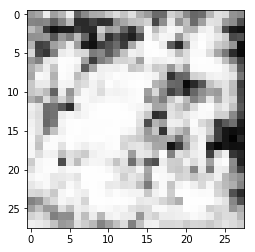

In [18]:
iterations = 3000
batch_size = 64
test_noise = np.random.normal(0, 1, (1, z_dims))

for it in range(iterations):
    train_disc(disc_model, gen_model, x_train, batch_size)
    train_gen(comb_model, batch_size)
    
    if it % 1000 == 0:
        print("epoch {}".format(it))
        plot_generated_img(test_noise)